In [1]:
from utils.openai_helpers import query_openai_model
from utils.preprocess_functions import convert_to_triplets, top_n_entities, triplets_containing_entity
from utils.preprocess_functions import get_labels_and_descriptions_for_triplets, format_triplets_text
from utils.wiki_helpers import get_label_for_qid, get_triplet_labels
from utils.prompt_functions import get_prompt_v1, get_prompt_v2
from utils.graph_plotting_helpers import plot_triplets_graph, plot_graph
# from utils.plotting_helpers import plot_count_distribution
import json

In [2]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman, label_propagation_communities
import community as community_louvain
from sklearn.cluster import SpectralClustering
from infomap import Infomap

In [3]:
import networkx as nx
# import cugraph as cnx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
with open('inputs/wikidata5m/wikidata5m_transductive_valid.txt', 'r') as file:
    wiki_valid = file.readlines()
with open('inputs/wikidata5m/wikidata5m_transductive_train.txt', 'r') as file:
    wiki_train = file.readlines()

In [5]:
list_of_triplets = convert_to_triplets(wiki_valid, numbersOnly=True)

In [6]:
# list_of_triplets = convert_to_triplets(wiki_train, numbersOnly=True)

In [7]:
list_of_triplets[:5]

[(3576734, 495, 30),
 (641724, 1412, 1860),
 (959357, 39, 49476),
 (4263990, 105, 7432),
 (4119101, 171, 2906912)]

In [8]:
len(list_of_triplets)

5163

In [9]:
list_of_triplets[:5]

[(3576734, 495, 30),
 (641724, 1412, 1860),
 (959357, 39, 49476),
 (4263990, 105, 7432),
 (4119101, 171, 2906912)]

In [10]:
def create_graph_from_triplets(triplets):
    """
    Creates a directed graph using cugraph from a list of triplets.
    Each triplet contains (source, relationship, destination).
    
    :param triplets: List of triplet tuples (source, relationship, destination)
    :return: A cugraph Graph or DiGraph object
    """
    G = nx.DiGraph()
    for src, rel, tgt in triplets:
        G.add_edge(src, tgt, relation=rel)

    return G


In [21]:
def remove_isolated_nodes(graph):
    """
    Remove isolated nodes (nodes with degree 0) from a NetworkX graph.

    Parameters:
    graph (networkx.Graph): A NetworkX graph.

    Returns:
    networkx.Graph: The graph with isolated nodes removed.
    """
    graph = nx.Graph(graph)
    # Identify isolated nodes
    isolated_nodes = [node for node, degree in graph.degree() if degree == 0]
    
    # Remove isolated nodes from the graph
    graph.remove_nodes_from(isolated_nodes)
    
    return graph

In [11]:
G = create_graph_from_triplets(list_of_triplets)

In [12]:
G.number_of_nodes()

8002

In [13]:
# from networkx.algorithms.community import greedy_modularity_communities

# def create_well_connected_subgraphs(G, min_size=5, max_size=15):
#     # Detect communities in the graph
#     communities = greedy_modularity_communities(G)
    
#     # Filter communities based on size constraints
#     valid_subgraphs = [G.subgraph(c).copy() for c in communities if min_size <= len(c) <= max_size]
    
#     return valid_subgraphs

In [14]:


def greedy_modularity_subgraphs(G, min_size=5, max_size=10000):
    communities = greedy_modularity_communities(G)
    return [G.subgraph(c).copy() for c in communities if min_size <= len(c) <= max_size]

def louvain_subgraphs(G, min_size=5, max_size=10000):
    partition = community_louvain.best_partition(G)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)
    return [G.subgraph(nodes).copy() for nodes in communities.values() if min_size <= len(nodes) <= max_size]

def girvan_newman_subgraphs(G, min_size=5, max_size=10000):
    comp = girvan_newman(G)
    communities = next(comp)
    return [G.subgraph(c).copy() for c in communities if min_size <= len(c) <= max_size]

def label_propagation_subgraphs(G, min_size=5, max_size=10000):
    communities = label_propagation_communities(G)
    return [G.subgraph(c).copy() for c in communities if min_size <= len(c) <= max_size]

def spectral_clustering_subgraphs(G, num_clusters, min_size=5, max_size=10000):
    adj_matrix = nx.to_numpy_array(G)
    sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize')
    labels = sc.fit_predict(adj_matrix)
    communities = {}
    for node, label in zip(G.nodes(), labels):
        communities.setdefault(label, []).append(node)
    return [G.subgraph(nodes).copy() for nodes in communities.values() if min_size <= len(nodes) <= max_size]

def infomap_subgraphs(G, min_size=5, max_size=10000):
    im = Infomap()
    for edge in tqdm(G.edges()):
        im.add_link(edge[0], edge[1])
    im.run()
    communities = {}
    for node in im.nodes:
        communities.setdefault(node.module_id, []).append(node.node_id)
    return [G.subgraph(nodes).copy() for nodes in communities.values() if min_size <= len(nodes) <= max_size]

def create_subgraphs(G, method, **kwargs):
    if method == 'greedy_modularity':
        return greedy_modularity_subgraphs(G, **kwargs)
    elif method == 'louvain':
        return louvain_subgraphs(G, **kwargs)
    elif method == 'girvan_newman':
        return girvan_newman_subgraphs(G, **kwargs)
    elif method == 'label_propagation':
        return label_propagation_subgraphs(G, **kwargs)
    elif method == 'spectral_clustering':
        return spectral_clustering_subgraphs(G, **kwargs)
    elif method == 'infomap':
        return infomap_subgraphs(G, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")



In [15]:
# # Example usage:
# G = nx.karate_club_graph()  # Replace with your large graph

# methods = ['greedy_modularity', 'louvain', 'girvan_newman', 'label_propagation', 'spectral_clustering', 'infomap']
# subgraphs_by_method = {}

# for method in methods:
#     try:
#         if method == 'spectral_clustering':
#             subgraphs = create_subgraphs(G, method, num_clusters=3)  # Adjust num_clusters as needed
#         else:
#             subgraphs = create_subgraphs(G, method)
#         subgraphs_by_method[method] = subgraphs
#         print(f"Method: {method}, Number of subgraphs: {len(subgraphs)}")
#     except Exception as e:
#         print(f"Method: {method} failed with error: {e}")


In [16]:
subgraphs = infomap_subgraphs(G)

100%|██████████| 5163/5163 [00:00<00:00, 329632.26it/s]


  Infomap v2.7.1 starts at 2024-05-18 19:04:16
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 4 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 8002 nodes and 5163 links...
  -> One-level codelength: 12.1873137

Trial 1/1 starting at 2024-05-18 19:04:16
Two-level compression: 82% 3.7e-10% 
Partitioned to codelength 0.000193685842 + 2.14810556 = 2.148299245 in 2840 modules.
Super-level compression: to codelength 2.148299245 in 2840 top modules.

Recursive sub-structure compression: 0.0168489497% 0% . Found 3 levels with codelength 2.14793728

=> Trial 1/1 finished in 0.118903998s with codelength 2.14793728


Summary after 1 trial
Best end modular solution in 3 levels:
Per level number of modules:         [       2840,           2,           0] (sum: 2842)
Pe

In [18]:
len(subgraphs)

142

In [19]:
subgraphs[0].number_of_nodes()

378

In [22]:
sgt = remove_isolated_nodes(subgraphs[0])

In [23]:
sgt.number_of_nodes()

378

In [25]:
sgt.nodes()

NodeView((5, 346118, 348170, 16934922, 1103892, 16201748, 3498012, 6285342, 1388576, 5482539, 7192619, 5984303, 542773, 1392694, 6205506, 15870018, 950340, 12601413, 7411798, 4189, 22280289, 3184760, 17404045, 7067799, 16185497, 55450, 7381147, 16214176, 37030, 12970154, 6107307, 6932661, 20707512, 5699774, 7108803, 17279178, 5386445, 692432, 319708, 2609373, 7182565, 6414574, 1818867, 5488889, 7627008, 5646593, 3557637, 217354, 821514, 7088397, 747790, 21479699, 3031319, 6074648, 6469914, 16062747, 4229404, 7358764, 1268022, 581943, 5085526, 7684446, 10557795, 5239140, 19863912, 551278, 6398325, 2703737, 16918906, 19882366, 209283, 7803278, 7313826, 6128051, 7915955, 1974712, 15460794, 2621888, 5300672, 17306063, 5126618, 2202075, 973276, 1163740, 1350112, 1384931, 5648871, 7244266, 25631216, 5761527, 33190393, 11174399, 13935109, 6779406, 3527195, 2075170, 7373352, 41187881, 5394993, 105014, 5163586, 17152578, 4018758, 555595, 23585358, 21176934, 4026984, 6937200, 4962933, 16196220, 

In [19]:
# #save subgraphs
# for i, subgraph in enumerate(subgraphs):
#     nx.write_gpickle(subgraph, f'outputs/subgraphs/infomap/subgraph_infomap_train_{i}.gpickle')

AttributeError: module 'networkx' has no attribute 'write_gpickle'

Bad pipe message: %s [b'~\x0c\xe7\x03\x11Ne\x10\xe1\x0f\x98\xea\xed\xa1n\xea\xf3| \x9c\xf9@S-\xfa\xff\x11O']
Bad pipe message: %s [b'\x0b\xb8\xd3\xaa\x90\x9d\x97\x1c\xd7\xe6\r50\x91\xd3v\xe1\xf4\x9c<u\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03']
Bad pipe message: %s [b"\xf8\xa5\x81\xf9\xd4\x05\x01$9W\n\xb2\xc7\x12\x05g\xe7\x9e\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j"]
Bad p

In [41]:
len(subgraphs)

142

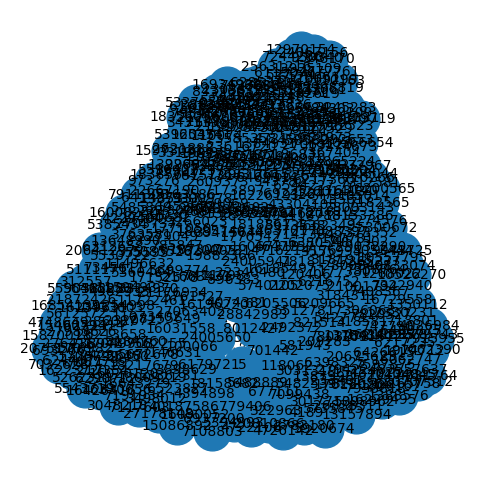

In [20]:
plot_graph(subgraphs[0])

In [25]:
def graph_properties(G):
    properties = {}
    
    degrees = [G.degree(n) for n in G.nodes()]
    properties['Degree Distribution'] = degrees


    properties['Clustering Coefficient'] = nx.average_clustering(G.to_undirected())

    if nx.is_strongly_connected(G):
        properties['Average Path Length'] = nx.average_shortest_path_length(G)
        properties['Diameter'] = nx.diameter(G)
    else:
        properties['Average Path Length'] = "Graph is not strongly connected."
        properties['Diameter'] = "Graph is not strongly connected."
    
    # Centrality Measures
    properties['Degree Centrality'] = nx.degree_centrality(G)
    properties['Closeness Centrality'] = nx.closeness_centrality(G)
    properties['Betweenness Centrality'] = nx.betweenness_centrality(G)
    
    # Connectivity
    properties['Node Connectivity'] = nx.node_connectivity(G)
    properties['Edge Connectivity'] = nx.edge_connectivity(G)
    
    # Assortativity
    properties['Assortativity Coefficient'] = nx.degree_assortativity_coefficient(G)
    
    return properties

In [43]:
graph_properties(subgraphs[8])

{'Degree Distribution': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  37,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'Clustering Coefficient': 0.0,
 'Average Path Length': 'Graph is not strongly connected.',
 'Diameter': 'Graph is not strongly connected.',
 'Degree Centrality': {2106496: 0.02702702702702703,
  9395460: 0.02702702702702703,
  2795909: 0.02702702702702703,
  1065741: 0.02702702702702703,
  5747342: 0.02702702702702703,
  14103: 0.02702702702702703,
  12700: 0.02702702702702703,
  6428575: 0.02702702702702703,
  8071584: 0.02702702702702703,
  6358050: 0.02702702702702703,
  166947: 0.02702702702702703,
  7075366: 0.02702702702702703,
  4266922: 0.02702702702702703,
  548525: 0.02702702702702703,
  2884273: 0.02702702702702703,
  454581: 0.02702702702702703,
  669245: 0.02702702702702703,
  5757117: 0.02702702702702703,
  525889: 0.02702702702702703,
  6723: 1.0,
  505284: 0